<a href="https://www.kaggle.com/code/anantaverma/agentic-rag-for-amazon-archaeology?scriptVersionId=247783289" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Agentic Multimodal RAG System for Archaeological Site Discovery  
## OpenAI to Z Challenge

This notebook presents an Agentic Multimodal Retrieval-Augmented Generation (RAG) system designed to assist in the discovery and interpretation of potential archaeological sites within the Amazon basin. The system integrates satellite imagery, historical expedition texts, and agent-based reasoning to simulate the cognitive process of a human researcher generating, justifying, and evaluating archaeological hypotheses.

## Dataset Overview

We utilize the following data sources:

- **Image Tiles**: Pre-processed Amazonian satellite tiles for visual inspection.
- **Textual Data**: Historical expedition logs and colonial documents.
- **Shapefiles**: LiDAR-detected deforestation zones.
- **Tile Bounds Metadata**: Geographic bounds for each tile.

## Historical Text Data

Our RAG pipeline draws on a curated set of digitized 19th-century exploration texts that document early European and American expeditions into the Amazon. These historical documents offer first-hand observations of indigenous cultures, environmental features, and settlement patterns that are invaluable for hypothesis generation.

### Books Used in This Project:

1. **Exploration of the Valley of the Amazon**
2. **A Narrative of Travels on the Amazon and Rio Negro** 
3. **A Voyage up the River Amazon, Including a Residence at Pará**
4. **The Amazon and Madeira Rivers**
---

These texts were chunked and embedded using `SentenceTransformer`, enabling retrieval during the user query phase. Together, they serve as a **rich semantic layer of historical memory** from which our generative agent forms hypotheses.

## System Architecture

The system follows a multimodal Agentic RAG pipeline:

1. **User Query** — accepts natural language research questions.
2. **Dual Retrieval** — fetches relevant text chunks and satellite image tiles using FAISS.
3. **Geographic Expansion Agent** — suggests diverse river regions based on retrieval results.
4. **LLM Hypothesis Agent** — proposes a detailed archaeological hypothesis.
5. **Justification Agent** — validates hypothesis using text and image evidence.
6. **Evaluation Agent** — assesses confidence and credibility.
7. **Folium Map** — visualizes relevant tiles with shapefile overlays and previews.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing
import os

file_paths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

# Print only summary + a few examples
print(f"Total files found: {len(file_paths)}")
print("Example files:")
for path in file_paths[:5]:  
    print("-", path)

Total files found: 93258
Example files:
- /kaggle/input/satelite-elevation/TAP_A01_14_DTM.tif
- /kaggle/input/satelite-elevation/TAP_A04_15_DTM.tif
- /kaggle/input/satelite-elevation/TAP_A05_16_DTM.tif
- /kaggle/input/satelite-elevation/prodes_brasil_2023.tif
- /kaggle/input/satelite-elevation/TAP_A06_17_DTM.tif


## User Query and Multimodal Retrieval

We start with a natural language query. Our system retrieves:
- Top `k` matching **text chunks** (via sentence-transformer)
- Top `k` matching **image tiles** (via CLIP)

In [3]:
# Install and import all required packages
!pip install -q geopandas rasterio matplotlib faiss-cpu torch folium textblob transformers sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 59.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 46.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.9 MB/s eta 0:00:00:00:0100:01


In [4]:
# # Install and import all required packages
import os
import pickle
import faiss
import torch
import folium
import geopandas as gpd
import numpy as np
from textblob import TextBlob
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
from IPython.display import display, Markdown

2025-06-28 05:04:19.153946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751087059.418464      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751087059.492478      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Embeddings and Models

In [5]:
# Load embeddings, indices, and metadata for both modalities
CLIP_INDEX_PATH = "/kaggle/input/embeddings/clip_tile_index.faiss"
CLIP_META_PATH = "/kaggle/input/embeddings/clip_tile_metadata.pkl"
TEXT_INDEX_PATH = "/kaggle/input/embeddings/text_index.faiss"
TEXT_META_PATH = "/kaggle/input/embeddings/text_metadata.pkl"
TILE_BOUNDS_PATH = "/kaggle/input/tile-bounds/tile_bounds.pkl"
TILE_DIR = "/kaggle/input/tiles/tiles"
LIDAR_SHP_DIR = "/kaggle/input/lidar-deforestation"

In [6]:
# ---------- LOAD MODELS ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
text_model = SentenceTransformer("all-MiniLM-L6-v2")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Storing the data in Faiss

In [7]:
# Load FAISS indices
def load_faiss_index(index_path):
    return faiss.read_index(index_path)

# Load metadata
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Load everything
clip_index = load_faiss_index(CLIP_INDEX_PATH)
clip_meta = load_pickle(CLIP_META_PATH)

text_index = load_faiss_index(TEXT_INDEX_PATH)
text_meta = load_pickle(TEXT_META_PATH)

tile_bounds = load_pickle(TILE_BOUNDS_PATH)

# Confirm loading
print(f"CLIP Index size: {clip_index.ntotal}")
print(f"Text Index size: {text_index.ntotal}")
print(f"Number of tile bounds: {len(tile_bounds)}")

CLIP Index size: 93220
Text Index size: 7336
Number of tile bounds: 93220


# Textblob for query check

In [8]:
# ---------- SPELL CORRECT ----------
def correct_query(query):
    return str(TextBlob(query).correct())

# ---------- EMBED QUERY ----------
def embed_query_clip(query):
    inputs = clip_processor(text=query, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        vector = clip_model.get_text_features(**inputs).cpu().numpy().astype("float32")
    return vector

def embed_query_text(query):
    return text_model.encode([query]).astype("float32")

# Embedding the user query

In [9]:
# Load SentenceTransformer model
text_embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Function to query text index
def retrieve_text_chunks(query, k=10):
    query_embed = text_embedder.encode([query])
    D, I = text_index.search(query_embed, k)

    text_chunks = text_meta["texts"]
    results = [text_chunks[i] if i < len(text_chunks) else f"[Missing chunk {i}]" for i in I[0]]
    return results

In [10]:
# Load CLIP Text Encoder
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to encode query with CLIP
def encode_clip_text(text):
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True)
    with torch.no_grad():
        return clip_model.get_text_features(**inputs).cpu().numpy()

# Function to query image tile index
def retrieve_tile_ids(query, k=10):
    query_embed = encode_clip_text(query)
    D, I = clip_index.search(query_embed, k)
    results = [clip_meta[i] for i in I[0]]
    return results

---

# Generative Component of the RAG Pipeline

In [11]:
from openai import OpenAI
import os
import openai

# If using Kaggle secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["OPENAI_API_KEY"] = user_secrets.get_secret("OPENAI_API_KEY")

# Initialize the client using your Kaggle environment variable
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [12]:

def run_geographic_expansion_agent(query, retrieved_texts):
    expansion_prompt = f"""
You are an archaeological reasoning assistant. The user asked:

"{query}"

You have access to historical text excerpts and satellite imagery tile references that may contain clues about river proximity, terrain, and prior settlements.

Your task is to:
- Analyze the following text chunks and satellite tile IDs
- Identify signs of multiple **distinct river systems or regions** mentioned or implied
- Propose 2–3 **alternative Amazon river regions** that could also be promising areas for human settlement based on the data retrieved or archaeological significance.

Only suggest rivers or regions if they are either:
- mentioned in the text, OR
- clearly inferred from the distribution or features in the imagery

Historical Texts:
{chr(10).join(['- ' + t for t in retrieved_texts])}
"""

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": expansion_prompt}],
        temperature=0.5
    )
    return response.choices[0].message.content.strip()

The core LLM agent uses the query, text, image tile matches, and suggested regions
to generate a scientific hypothesis grounded in historical and visual data.

In [13]:
import openai
import os

# 🔐 Load OpenAI API key from Kaggle secrets or environment
openai.api_key = os.environ.get("OPENAI_API_KEY")  # Ensure this is set in Kaggle secrets

# ✅ Hypothesis generator with structured response
def generate_hypothesis(query, text_chunks, top_tiles=None, expanded_regions=None):
    tile_references = ""
    if top_tiles:
        tile_references = "\n".join([f"- {tile}" for tile in top_tiles[:5]])

    prompt = f"""
You are an expert archaeological assistant with access to both historical texts and satellite imagery.

User query: {query}

You are given the following historical text excerpts:
{text_chunks}

You are also provided with satellite image tiles that exhibit notable landscape features:
{tile_references}
"""
    if expanded_regions:
        prompt += f"""

Additionally, you are encouraged to consider these other potentially relevant regions based on known Amazonian settlement patterns:
{expanded_regions}

Based on both the historical text and image references, provide a detailed and academically grounded hypothesis about what these features may represent. Be specific in your analysis, referencing past known civilizations, agricultural or ceremonial patterns, or any anthropogenic shapes like rectangles, grids, or radial structures that are visible.

Structure your output like this:
**Hypothesis**
...

**Justification**
...

Use clear language that could be understood by a research reviewer or geospatial archaeologist.
"""

    client = openai.OpenAI()

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.4
    )
    
    return response.choices[0].message.content.strip()

# Map Integration

In [14]:
import folium
from folium import IFrame
import base64
import os
import geopandas as gpd
import branca.colormap as cm

def render_tile_map(tile_ids, tile_bounds, hypothesis=None, confidence_scores=None):
    default_location = [-3.4653, -62.2159]
    fmap = folium.Map(location=default_location, zoom_start=5)

    for i, tile_id in enumerate(tile_ids):
        if tile_id not in tile_bounds:
            continue
        lat_min, lon_min, lat_max, lon_max = tile_bounds[tile_id]
        bounds = [[lat_min, lon_min], [lat_max, lon_max]]

        # Load image and encode as base64
        image_path = os.path.join(TILE_DIR, tile_id)
        encoded_img = ""
        if os.path.exists(image_path):
            with open(image_path, 'rb') as f:
                encoded_img = base64.b64encode(f.read()).decode()
        
        # Optional confidence for color
        score = confidence_scores[i] if confidence_scores else 0.5
        color = "green" if score >= 0.75 else "orange" if score >= 0.5 else "red"

        html = f"<b>{tile_id}</b><br>"
        if encoded_img:
            html += f'<img src="data:image/png;base64,{encoded_img}" width="200" />'

        popup = folium.Popup(IFrame(html, width=210, height=220), max_width=250)

        folium.Rectangle(
            bounds=bounds,
            color=color,
            fill=True,
            fill_opacity=0.4,
            popup=popup
        ).add_to(fmap)

    if hypothesis:
        folium.Marker(
            location=default_location,
            icon=folium.Icon(color='green'),
            popup=hypothesis[:300]
        ).add_to(fmap)

    return fmap
    
def add_shapefile_overlay(fmap, shp_dir, max_features=500):
    for fname in os.listdir(shp_dir):
        if fname.endswith(".shp"):
            path = os.path.join(shp_dir, fname)
            gdf = gpd.read_file(path)
            if len(gdf) > max_features:
                gdf = gdf.sample(max_features)  # subsample
            folium.GeoJson(gdf, name=fname).add_to(fmap)
    return fmap

## Agents for Justification and Evaluation

We use two additional agents:
- **Justification Agent**: Checks alignment of hypothesis with source data
- **Evaluation Agent**: Adds a confidence score and flags uncertainty

In [15]:
def run_justification_agent(query, text_chunks, tile_ids, llm_hypothesis):
    justification_prompt = f"""
You are a scientific reasoning agent. Your task is to verify whether the following hypothesis is well-supported by the provided data.

User Query:
{query}

Hypothesis:
{llm_hypothesis}

Supporting Text Chunks:
{chr(10).join(['- ' + chunk for chunk in text_chunks])}

Referenced Image Tile IDs:
{tile_ids}

Please return a structured justification. Highlight which parts of the hypothesis are strongly supported, weakly supported, or unsupported based on the data.
"""
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": justification_prompt}],
        temperature=0.3
    )

    return response.choices[0].message.content.strip()

In [16]:
def run_evaluation_agent(hypothesis, justification):
    evaluation_prompt = f"""
You are an evaluator AI assessing the scientific credibility of a hypothesis and its justification.

Hypothesis:
{hypothesis}

Justification:
{justification}

Please evaluate the overall credibility and clarity of the hypothesis. Return:

### Evaluation
- Confidence Score (1–10): X/10
- Major Strengths:
- Limitations or Uncertainty Factors:
- Should this be pursued further? (Yes/No and Why)
"""
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": evaluation_prompt}],
        temperature=0.3
    )

    return response.choices[0].message.content.strip()

## User Query and Multimodal RAG

We start with a natural language query. Our system retrieves:
- Top `k` matching **text chunks** (via sentence-transformer)
- Top `k` matching **image tiles** (via CLIP)

Final Hypothesis, Justification, and Evaluation

In [17]:
#change your query here
query = "Where might ancient settlements exist near major rivers in the Amazon?"

# Step 1: Retrieve
text_results = retrieve_text_chunks(query, k=10)
image_results = retrieve_tile_ids("circular mound structures", k=10)

# Step 2: Expand regionally
expanded_regions = run_geographic_expansion_agent(query, text_results)

# Step 3: Generate hypothesis
hypothesis_output = generate_hypothesis(
    query=query,
    text_chunks="\n\n".join(text_results),
    top_tiles=image_results,
    expanded_regions=expanded_regions
)

# Step 4: Justify + Evaluate
justification = run_justification_agent(query, text_results, image_results, hypothesis_output)
evaluation = run_evaluation_agent(hypothesis_output, justification)

# map_output = add_shapefile_overlay(map_output, LIDAR_SHP_DIR)
# display(map_output)

# Step 6: Show output
print("Hypothesis:\n", hypothesis_output)
print("\nJustification:\n", justification)
print("\nEvaluation:\n", evaluation)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Hypothesis:
 **Hypothesis**

The features identified in the historical texts and satellite imagery suggest the existence of ancient settlements along the Amazon River and its major tributaries, including the Madeira, Uaupés, Tocantins, Mamore, Guapore, and Uaycali Rivers. These settlements may have been inhabited by the native American tribes mentioned in the texts, and their locations near major rivers suggest they may have relied on fishing and hunting for sustenance. The figures on the granite rocks along the Uaupés River suggest the presence of rock art, which could indicate ceremonial or cultural significance. The satellite images may reveal anthropogenic shapes like rectangles, grids, or radial structures that could represent the remains of these settlements, such as building foundations, agricultural fields, or ceremonial sites.

**Justification**

The Amazon River and its tributaries are known to have been home to numerous indigenous tribes, many of whom left behind traces of t

## Interactive Map and Visualization

- Tiles are shown with bounding rectangles
- Deforestation shapefiles are overlaid for contextual insights

In [18]:
# Display top-k image tile matches as thumbnails for visual reference
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_top_tiles(tile_ids, tile_dir=TILE_DIR, size=(150, 150)):
    """
    Display top image tiles used in RAG with resized thumbnails.
    """
    num_tiles = min(len(tile_ids), 10)
    fig, axes = plt.subplots(1, num_tiles, figsize=(num_tiles * 2, 2.5))
    
    if num_tiles == 1:
        axes = [axes]  # ensure iterable if only one tile
    
    for i in range(num_tiles):
        tile_path = os.path.join(tile_dir, tile_ids[i])
        try:
            img = Image.open(tile_path).resize(size)
            axes[i].imshow(img)
            axes[i].set_title(tile_ids[i][:20], fontsize=8)
            axes[i].axis("off")
        except Exception as e:
            axes[i].set_title("Missing", fontsize=8)
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

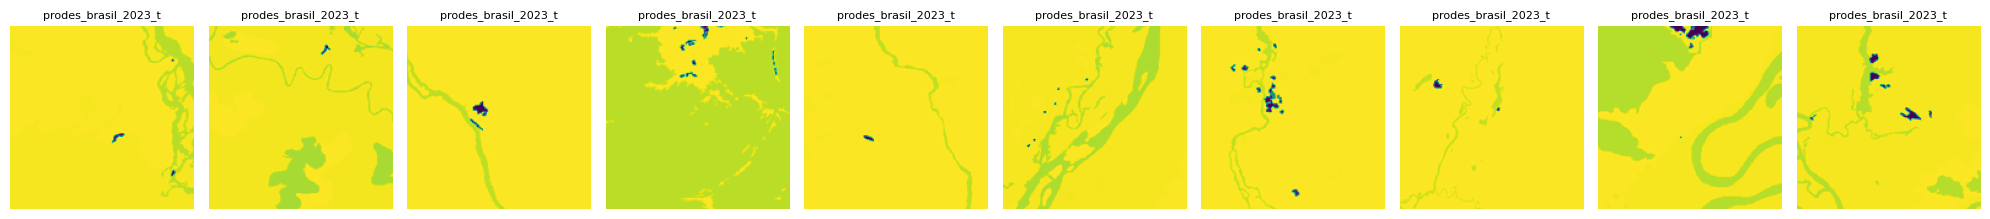

In [19]:
show_top_tiles(image_results)

In [20]:
from IPython.display import display

tile_ids = image_results

map_out = render_tile_map(tile_ids, tile_bounds, hypothesis=hypothesis_output)

# Add .shp overlays (optional)
map_out = add_shapefile_overlay(map_out, LIDAR_SHP_DIR)

# Display
display(map_out)

## Map View: Satellite Tile Predictions + Deforestation Activity

This map visualizes the system’s reasoning outputs in geospatial form:

### 🟠 Orange Rectangles

* Represent **top-matching satellite image tiles** retrieved by CLIP for the given user query.
* These are the regions the model considers visually relevant (e.g., showing circular mounds or rectilinear structures) for archaeological investigation.

### 🟢 Green Marker

* Indicates the **center of hypothesis generation**.
* It marks the approximate center of the region the LLM focused on when generating its archaeological hypothesis.

### 🔵 Blue Dots

* These come from **deforestation shapefile overlays** (e.g., `deter-amz-deter-public.shp`).
* Each polygon or point represents a **recorded deforestation event** or **burn scar**, classified as:

  * `CICATRIZ_DE_QUEIMADA` – Burned scar
  * `CS_GEOMETRICO` – Geometric clearing
* Many of these occur even within protected areas, and may coincide with or obscure potential archaeological features.

## Conclusion, Limitations and Future Work

This notebook demonstrates a novel use of multimodal RAG with agents to form scientifically plausible hypotheses about past civilizations. While this system shows strong potential, there are several important limitations:

* **Data Scale**: The dataset is small, ie, only a few historical texts and limited satellite tiles as compared to the vast archaeological possibilities across the Amazon.
* **Static Inputs**: All embeddings are precomputed; no real-time data or user-uploaded imagery is currently supported.
* **Limited Accuracy**: Hypotheses are not validated against known archaeological site databases or fieldwork.
* **Modal Simplicity**: We use only RGB imagery
* **LLM Fragility**: Despite agentic structuring, reasoning can still be speculative without deeper fine-tuning or constraints.

This prototype demonstrates the feasibility of an agentic RAG workflow for archaeology, and offers a strong foundation for future, more robust systems.